# Dimensionality Reduction

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.datasets import load_iris
from keras.utils import to_categorical
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

sns.set()

In [17]:
def cluestering(dataset, algorithm: str, n_clusters: int, out_file_name: str=None):
	if type(dataset) == str:
		df = pd.read_csv(dataset, ',', header=None)
	elif type(dataset) == pd.DataFrame:
		df = dataset
	else:
		try:
			df = pd.DataFrame(dataset)
		except ValueError:
			raise TypeError("dataset must be a pandas dataframe or a path to a csv file")
	if algorithm == "kmeans":
		algo = KMeans(
			n_clusters=n_clusters,
			n_init=30
		)
	elif algorithm == "EM":
		algo = GaussianMixture(
			n_components=n_clusters,
			n_init=30,
			init_params='kmeans'  # can also be kmeans or random !
		)
	else:
		raise ValueError("algorithm must be one of 'kmeans' or 'EM'")
	algo.fit(X=df)
	p = algo.predict(X=df)
	dfp = df.assign(label=p)
	if out_file_name is not None:
		dfp.to_csv(out_file_name, sep=',', encoding='utf-8', header=None)
	return dfp, algo

def load_iris_to_df():
	iris = load_iris()
	df = pd.DataFrame(iris['data'], columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
	df = df.assign(label=iris['target'])
	return df

def load_gender_to_df():
	df = pd.read_csv("../data/gender_x_all.csv", header=0)
	# normalize data set
	min_df, max_df = np.min(df, 0), np.max(df, 0)
	df[:] -= min_df
	df[:] /= max_df - min_df
	# add label
	df_lb = pd.read_csv("../data/gender_y_all.csv", header=0)
	df = df.assign(label=df_lb['label'])
	return df

def plot_2d(df: pd.DataFrame, x_axis: str, y_axis: str, label_axis: str='label', comment=""):
	fig, ax = plt.subplots()
	ax.scatter(df.get(x_axis), df.get(y_axis), c=df.get(label_axis), cmap='gist_ncar', linewidths=1, edgecolors='black')
	ax.set_xlabel(x_axis.replace('_', ' '), fontsize=15)
	ax.set_ylabel(y_axis.replace('_', ' '), fontsize=15)
	if comment != "":
		comment += "_"
	plt.savefig("../graphics/" + comment + x_axis + "_" + y_axis + "_" + label_axis + ".png")
	plt.show()

def plot_3d(df: pd.DataFrame, x_axis: str, y_axis: str, z_axis: str, label_axis: str='label', comment=""):
	fig = plt.figure()
	ax = fig.add_subplot(111, projection='3d')
	ax.scatter(df.get(x_axis), df.get(y_axis), df.get(z_axis), c=df.get(label_axis), s=5, depthshade=False, cmap='gist_ncar')
	ax.set_xlabel(x_axis.replace('_', ' '), fontsize=10)
	ax.set_ylabel(y_axis.replace('_', ' '), fontsize=10)
	ax.set_zlabel(z_axis.replace('_', ' '), fontsize=10)
	if comment != "":
		comment += "_"
	plt.savefig("../graphics/3D_" + comment + x_axis + "_" + y_axis + "_" + z_axis + "_" + label_axis + ".png")
	plt.show()
	
def reduce_dimension(dataset, algorithm: str, nb_of_dimention: int, out_file=None, plot_curve=False, labels=None):
	if type(dataset) == str:
		df = pd.read_csv(dataset, ',', header=None)
	elif type(dataset) == pd.DataFrame:
		df = dataset
	else:
		try:
			df = pd.DataFrame(dataset)
		except ValueError:
			raise TypeError("dataset must be a pandas dataframe or a path to a csv file")
	if algorithm == "PCA":
		algo = PCA(
			n_components=nb_of_dimention,
			svd_solver='full'
		)
	elif algorithm == 'ICA':
		algo = FastICA(
			n_components=nb_of_dimention
		)
	elif algorithm == 'random':
		algo = GaussianRandomProjection(
			n_components=nb_of_dimention
		)
	elif algorithm == 'LDA':
		algo = LinearDiscriminantAnalysis(
			n_components=nb_of_dimention,
			solver='eigen',
			shrinkage='auto'
		)
		if labels is None:
			raise ValueError("Labels must be given when using LDA algorithm (but are use less in other case)")
	else:
		raise ValueError("Unknow algorithm, please use one of: 'PCA', 'ICA', 'LDA' or 'random'")
	algo.fit(
		X=df,
		y=labels
	)
	tdf = algo.transform(X=df)
	tdf = pd.DataFrame(tdf, columns=list(map(str, range(nb_of_dimention))))
	if out_file is not None:
		tdf.to_csv(out_file, sep=',', encoding='utf-8')
	if plot_curve:
		if algorithm == 'PCA':
			eigenvalues = algo.explained_variance_
			score_list = np.zeros((2, len(eigenvalues)), dtype=np.float64)
			old_sum = 0.0
			for i, v in enumerate(eigenvalues):
				old_sum += v
				score_list[0, i] = old_sum
				score_list[1, i] = v
			plt.figure(1)
			plt.plot(range(len(eigenvalues)), score_list[0] / np.max(score_list[0]), label="normalized eigenvalue sum")
			plt.plot(range(len(eigenvalues)), score_list[1] / np.max(score_list[1]), label="normalized eigenvalues")
			plt.legend()
			plt.xlabel("Dimension")
			plt.savefig("../graphics/" + algorithm + "_dimension_importance_" + str(nb_of_dimention) + ".png")
			plt.show()
		elif algorithm == 'LDA':
			# print(algo.covariance_)
			eigenvalues = np.diag(algo.covariance_).copy()
			eigenvalues.sort()
			eigenvalues = np.flip(eigenvalues, 0)
			score_list = np.zeros((2, len(eigenvalues)), dtype=np.float64)
			old_sum = 0.0
			for i, v in enumerate(eigenvalues):
				old_sum += v
				score_list[0, i] = old_sum
				score_list[1, i] = v
			plt.figure(1)
			plt.plot(range(len(eigenvalues)), score_list[0] / np.max(score_list[0]), label="normalized eigenvalue sum")
			plt.plot(range(len(eigenvalues)), score_list[1] / np.max(score_list[1]), label="normalized eigenvalues")
			plt.legend()
			plt.xlabel("Dimension")
			# plt.savefig("../graphics/" + algorithm + "_dimension_importance_" + str(nb_of_dimention) + ".png")
			plt.show()
		else:
			raise ValueError('Curve not yet implemented for other algorithm than PCA')
	return tdf, algo

## Iris Dataset

/tmp/ipykernel_91568/3248834940.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  iris = iris.drop('label', 1)


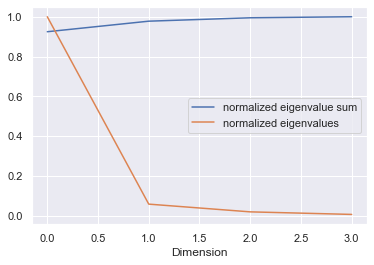

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


In [18]:
iris = load_iris_to_df()
iris_label = iris.get('label')
iris = iris.drop('label', 1)
pca_iris, _ = reduce_dimension(iris, 'PCA', 4, plot_curve=True)
pca_iris, _ = reduce_dimension(iris, 'PCA', 2, plot_curve=False)
ica_iris, _ = reduce_dimension(iris, 'ICA', 2)
rnd_iris, _ = reduce_dimension(iris, 'random', 2)
lda_iris, _ = reduce_dimension(iris, 'LDA', 2, labels=iris_label)

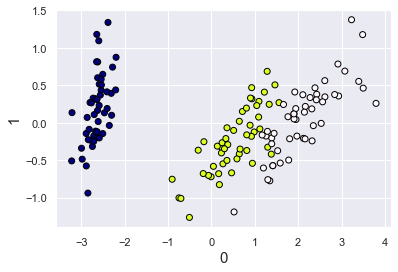

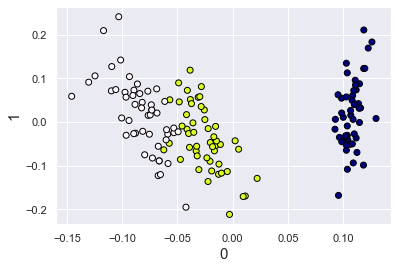

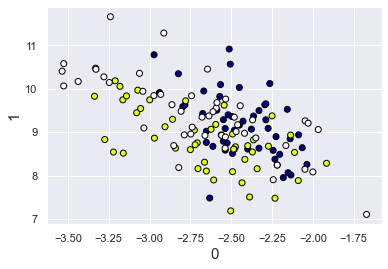

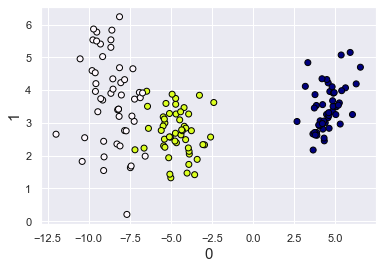

In [19]:
plot_2d(pca_iris.assign(label=iris_label), "0", "1", comment="pca_iris")
plot_2d(ica_iris.assign(label=iris_label), "0", "1", comment="ica_iris")
plot_2d(rnd_iris.assign(label=iris_label), "0", "1", comment="rnd_iris")
plot_2d(lda_iris.assign(label=iris_label), "0", "1", comment="lda_iris")

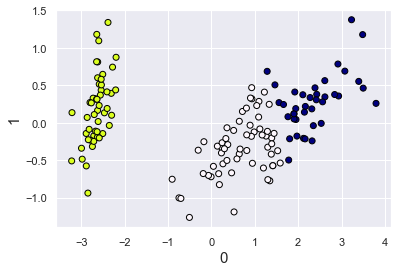

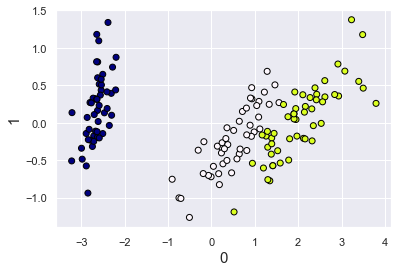

In [20]:
kmeans_pca_iris = cluestering(pca_iris, 'kmeans', 3)[0]
em_pca_iris = cluestering(pca_iris, 'EM', 3)[0]
plot_2d(kmeans_pca_iris, "0", "1", comment="pca_iris_kmeans")
plot_2d(em_pca_iris, "0", "1", comment="pca_iris_EM")

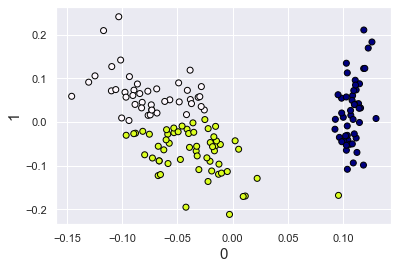

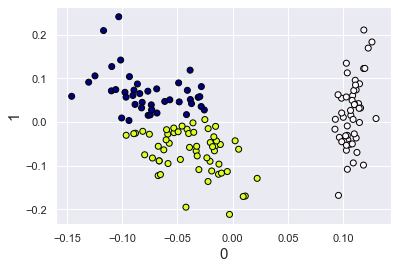

In [21]:
kmeans_ica_iris = cluestering(ica_iris, 'kmeans', 3)[0]
em_ica_iris = cluestering(ica_iris, 'EM', 3)[0]
plot_2d(kmeans_ica_iris, "0", "1", comment="ica_iris_kmeans")
plot_2d(em_ica_iris, "0", "1", comment="ica_iris_EM")

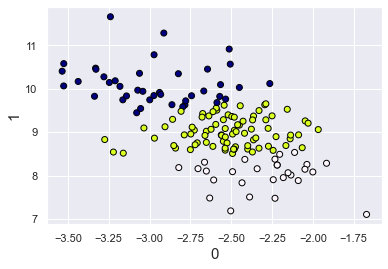

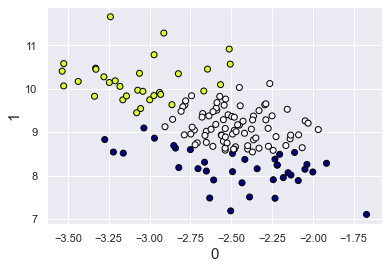

In [22]:
kmeans_rnd_iris = cluestering(rnd_iris, 'kmeans', 3)[0]
em_rnd_iris = cluestering(rnd_iris, 'EM', 3)[0]
plot_2d(kmeans_rnd_iris, "0", "1", comment="rnd_iris_kmeans")
plot_2d(em_rnd_iris, "0", "1", comment="rnd_iris_EM")

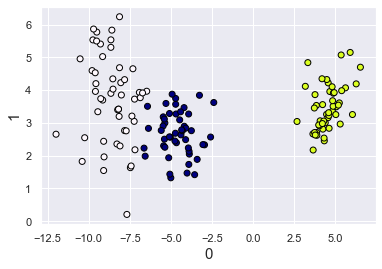

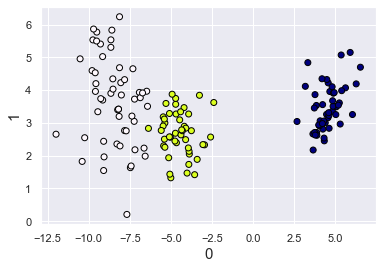

In [23]:
kmeans_lda_iris = cluestering(lda_iris, 'kmeans', 3)[0]
em_lda_iris = cluestering(lda_iris, 'EM', 3)[0]
plot_2d(kmeans_lda_iris, "0", "1", comment="lda_iris_kmeans")
plot_2d(em_lda_iris, "0", "1", comment="lda_iris_EM")

## Gendata Dataset

/tmp/ipykernel_91568/767939289.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  g = g.drop('label', 1)


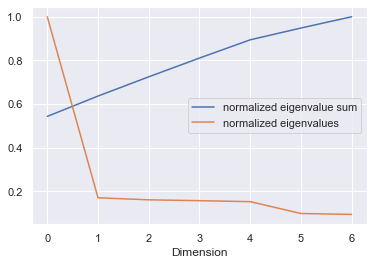

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


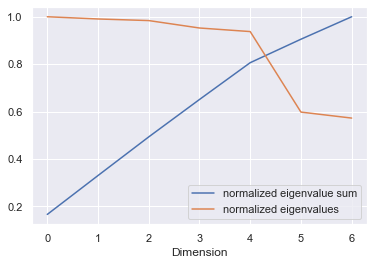

In [24]:
g = load_gender_to_df()
g_label = g.get('label')
g = g.drop('label', 1)
pca_g, _ = reduce_dimension(g, 'PCA', 7, plot_curve=True)
pca_g, _ = reduce_dimension(g, 'PCA', 2, plot_curve=False)
ica_g, _ = reduce_dimension(g, 'ICA', 2)
rnd_g, _ = reduce_dimension(g, 'random', 2)
lda_g, _ = reduce_dimension(g, 'LDA', 1, labels=g_label, plot_curve=True)

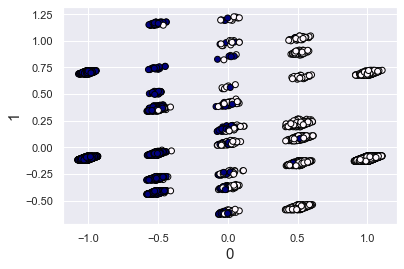

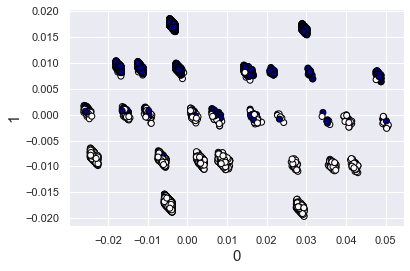

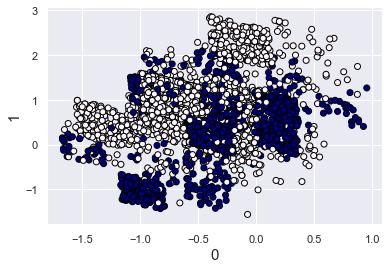

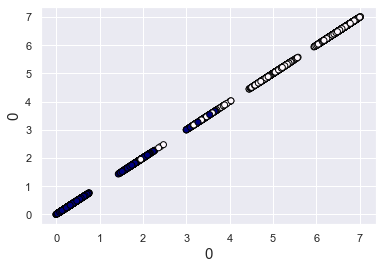

In [25]:
plot_2d(pca_g.assign(label=g_label), "0", "1", comment="pca_g")
plot_2d(ica_g.assign(label=g_label), "0", "1", comment="ica_g")
plot_2d(rnd_g.assign(label=g_label), "0", "1", comment="rnd_g")
plot_2d(lda_g.assign(label=g_label), "0", "0", comment="lda_g")

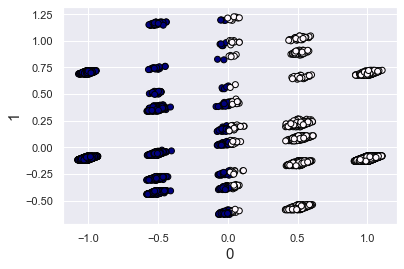

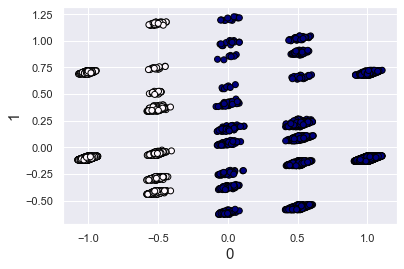

In [26]:
kmeans_pca_g = cluestering(pca_g, 'kmeans', 2)[0]
em_pca_g = cluestering(pca_g, 'EM', 2)[0]
plot_2d(kmeans_pca_g, "0", "1")
plot_2d(em_pca_g, "0", "1")

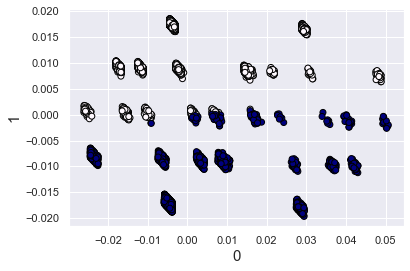

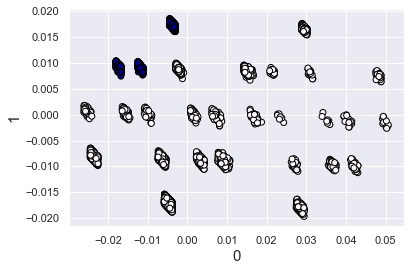

In [27]:
kmeans_ica_g = cluestering(ica_g, 'kmeans', 2)[0]
em_ica_g = cluestering(ica_g, 'EM', 2)[0]
plot_2d(kmeans_ica_g, "0", "1", comment="ica_g_kmeans")
plot_2d(em_ica_g, "0", "1", comment="ica_g_EM")

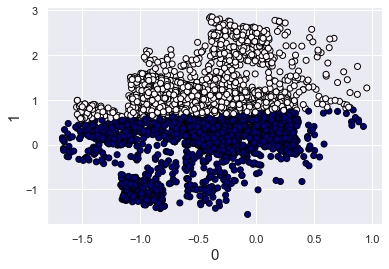

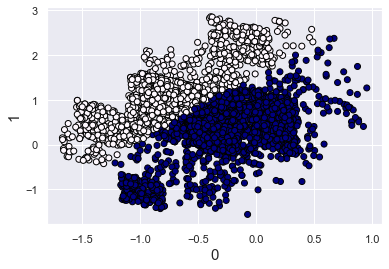

In [28]:
kmeans_rnd_g = cluestering(rnd_g, 'kmeans', 2)[0]
em_rnd_g = cluestering(rnd_g, 'EM', 2)[0]
plot_2d(kmeans_rnd_g, "0", "1", comment="rnd_g_kmeans")
plot_2d(em_rnd_g, "0", "1", comment="rnd_g_EM")

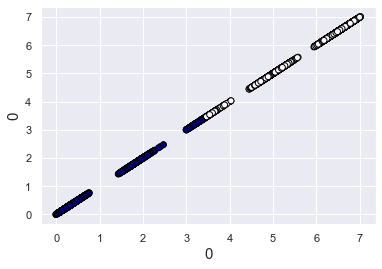

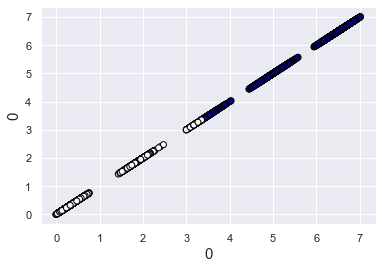

In [31]:
kmeans_lda_g = cluestering(lda_g, 'kmeans', 2)[0]
em_lda_g = cluestering(lda_g, 'EM', 2)[0]
plot_2d(kmeans_lda_g, "0", "0", comment="lda_g_kmeans")
plot_2d(em_lda_g, "0", "0", comment="lda_g_EM")